<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Libraries" data-toc-modified-id="Load-Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Libraries</a></span></li><li><span><a href="#Prepare-Data" data-toc-modified-id="Prepare-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Prepare Data</a></span><ul class="toc-item"><li><span><a href="#Adjust-Units-of-Measurements" data-toc-modified-id="Adjust-Units-of-Measurements-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Adjust Units of Measurements</a></span></li><li><span><a href="#Consolidate-Information-about-Lines" data-toc-modified-id="Consolidate-Information-about-Lines-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Consolidate Information about Lines</a></span></li><li><span><a href="#Convert-Runtime-into-Expected-Drive-Time-and-Dwell-Time" data-toc-modified-id="Convert-Runtime-into-Expected-Drive-Time-and-Dwell-Time-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Convert Runtime into Expected Drive Time and Dwell Time</a></span></li></ul></li><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Exploratory Data Analysis</a></span><ul class="toc-item"><li><span><a href="#Distance-Between-Stations-(m)" data-toc-modified-id="Distance-Between-Stations-(m)-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Distance Between Stations (m)</a></span></li><li><span><a href="#Drive-Time-between-Stations-(s)" data-toc-modified-id="Drive-Time-between-Stations-(s)-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Drive Time between Stations (s)</a></span></li><li><span><a href="#Dwell-Times-(s)" data-toc-modified-id="Dwell-Times-(s)-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Dwell Times (s)</a></span></li></ul></li><li><span><a href="#Modelling" data-toc-modified-id="Modelling-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Modelling</a></span><ul class="toc-item"><li><span><a href="#Trains" data-toc-modified-id="Trains-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Trains</a></span></li><li><span><a href="#Tracks" data-toc-modified-id="Tracks-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Tracks</a></span></li></ul></li><li><span><a href="#Utilities" data-toc-modified-id="Utilities-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Utilities</a></span></li><li><span><a href="#System-Verification" data-toc-modified-id="System-Verification-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>System Verification</a></span></li><li><span><a href="#References" data-toc-modified-id="References-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>References</a></span></li></ul></div>

# Load Libraries

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import numpy as np

import simpy

# Prepare Data

In [2]:
dt=pd.read_csv('LondonTube.csv')

In [3]:
dt.head()

,Line,Direction,From,To,Distance,Running Time,Peak Running Time,Off-Peak Running Time
0,Bakerloo,Southbound,HARROW & WEALDSTONE,KENTON,1.74,2.23,2.50,2.50
1,Bakerloo,Southbound,KENTON,SOUTH KENTON,1.40,1.88,2.00,2.00
2,Bakerloo,Southbound,SOUTH KENTON,NORTH WEMBLEY,0.90,1.50,1.50,1.50
3,Bakerloo,Southbound,NORTH WEMBLEY,WEMBLEY CENTRAL,1.27,1.92,2.06,2.06
4,Bakerloo,Southbound,WEMBLEY CENTRAL,STONEBRIDGE PARK,1.71,2.23,3.13,3.13


## Adjust Units of Measurements

Convert distances to meters

In [6]:
dt['Distance']=dt['Distance'].apply(lambda x: int(x*1000))

Convert running times into seconds

In [7]:
dt['Running Time']=dt['Running Time'].apply(lambda x: int(x*60))
dt['Peak Running Time']=dt['Peak Running Time'].apply(lambda x: int(x*60))
dt['Off-Peak Running Time']=dt['Off-Peak Running Time'].apply(lambda x: int(x*60))

In [8]:
dt.head()

,Line,Direction,From,To,Distance,Running Time,Peak Running Time,Off-Peak Running Time
0,Bakerloo,Southbound,HARROW & WEALDSTONE,KENTON,1740,133,150,150
1,Bakerloo,Southbound,KENTON,SOUTH KENTON,1400,112,120,120
2,Bakerloo,Southbound,SOUTH KENTON,NORTH WEMBLEY,900,90,90,90
3,Bakerloo,Southbound,NORTH WEMBLEY,WEMBLEY CENTRAL,1270,115,123,123
4,Bakerloo,Southbound,WEMBLEY CENTRAL,STONEBRIDGE PARK,1710,133,187,187


## Consolidate Information about Lines

Note: A short looping branch line of the Central Line has been deleted from the original data set.

In [4]:
list(dt['Line'].unique())

['Bakerloo',
 'Central',
 'Victoria',
 'Waterloo & City',
 'Jubilee',
 'Northern',
 'Piccadilly',
 'Metropolitan',
 'H & C',
 'Circle',
 'District',
 'East London']

In [5]:
list(dt.Direction.unique())

['Southbound', 'Northbound', 'Eastbound', 'Westbound', 'Inner', 'Outer']

Note: Each line has its specific rolling stock with drive parameters depending on the track geometry, electrical power supply, and the year of construction. For simplicity we assume fixed parameters across the network.  

In [38]:
lines=dt['Line'].unique()
dl=pd.DataFrame(lines, columns=['Line'])
dl=dl.set_index('Line')

dl['Direction 1']=None
dl['Direction 2']=None
dl['Stations']=None
dl['Total Dist']=None
dl['Min Dist']=None
dl['Avg Dist']=None
dl['Max Dist']=None

dl['max a']=0.7
dl['max v']=25

for l in lines:
    
    dirs = dt[dt['Line']==l]['Direction'].unique()
    dirs = sorted(list(dirs))
    dl.at[l, 'Direction 1']=dirs[0]
    dl.at[l, 'Direction 2']=dirs[1]
    
    dist = dt[dt['Line']==l]['Distance']
    dl.at[l, 'Stations']=int(dist.count()/2)
    dl.at[l, 'Total Dist']=int(dist.sum()/2)
    dl.at[l, 'Min Dist']=int(dist.min())
    dl.at[l, 'Avg Dist']=int(dist.mean())
    dl.at[l, 'Max Dist']=int(dist.max())

dl

,Direction 1,Direction 2,Stations,Total Dist,Min Dist,Avg Dist,Max Dist,max a,max v
Line,,,,,,,,,
Bakerloo,Northbound,Southbound,24,23230,370,967,1740,0.7,25
Central,Eastbound,Westbound,45,67520,400,1500,3340,0.7,25
Victoria,Northbound,Southbound,15,21250,740,1416,3150,0.7,25
Waterloo & City,Eastbound,Westbound,1,2370,2370,2370,2370,0.7,25
Jubilee,Eastbound,Westbound,26,36950,440,1421,2850,0.7,25
Northern,Northbound,Southbound,51,57700,270,1131,2460,0.7,25
Piccadilly,Eastbound,Westbound,49,66874,250,1350,4420,0.7,25
Metropolitan,Eastbound,Westbound,35,87689,510,2505,11630,0.7,25
H & C,Eastbound,Westbound,27,25410,510,941,2290,0.7,25


## Convert Runtime into Expected Drive Time and Dwell Time

Physics Calculation: time to travel a given distance based on acceleration and max velocity

In [10]:
def timeTo(a, maxV, d):
    # a       constant acceleration, m/s²
    # maxV    maximumum velocity, m/s
    # d       distance, km
    # return  time in seconds required to travel
    # 
    ta = maxV/a         # time to accelerate to maxV
    da = a*ta**2        # distance traveled during acceleration from 0 to maxV and back to 0
    if (d < da):        # train never reaches full speed?
        return np.sqrt(4.0*d/a)     # time needed to accelerate to half-way point then decelerate to destination
    else:
        return 2*ta + (d-da)/maxV   # time to accelerate to maxV plus travel at maxV plus decelerate to destination

In [11]:
dt['Drive Time'] = None
for i in range(len(dt)):
    dist = dt.at[i, 'Distance']
    l = dt.at[i, 'Line']
    a = dl.at[l, 'max a']
    v = dl.at[l, 'max v']
    dt.at[i, 'Drive Time']=int(timeTo(a, v, dist))

In [13]:
dt['Dwell Time']=dt['Running Time']-dt['Drive Time']

In [14]:
dt['Peak Dwell Time']=dt['Peak Running Time']-dt['Drive Time']

In [15]:
dt['Off-Peak Dwell Time']=dt['Off-Peak Running Time']-dt['Drive Time']

In [39]:
dt=dt.drop(columns=['Running Time', 'Peak Running Time', 'Off-Peak Running Time'])

In [40]:
dt.head()

,Line,Direction,From,To,Distance,Drive Time,Dwell Time,Peak Dwell Time,Off-Peak Dwell Time
0,Bakerloo,Southbound,HARROW & WEALDSTONE,KENTON,1740,105,28,45,45
1,Bakerloo,Southbound,KENTON,SOUTH KENTON,1400,91,21,29,29
2,Bakerloo,Southbound,SOUTH KENTON,NORTH WEMBLEY,900,71,19,19,19
3,Bakerloo,Southbound,NORTH WEMBLEY,WEMBLEY CENTRAL,1270,86,29,37,37
4,Bakerloo,Southbound,WEMBLEY CENTRAL,STONEBRIDGE PARK,1710,104,29,83,83


# Exploratory Data Analysis

## Distance Between Stations (m)

In [42]:
dt['Distance'].min()

250

In [43]:
dt['Distance'].max()

11630

In [46]:
dt['Distance'].mean()

1304.2723521320495

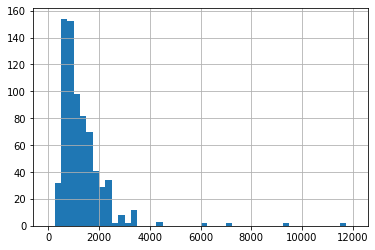

In [45]:
dt['Distance'].hist(bins=np.linspace(0, 12000, 49))

## Drive Time between Stations (s)

In [48]:
dt['Drive Time'].min()

37

In [49]:
dt['Drive Time'].max()

500

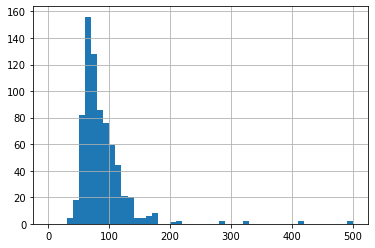

In [50]:
dt['Drive Time'].hist(bins=np.linspace(0, 500, 51))

## Dwell Times (s)

In [22]:
dt['Peak Dwell Time'].min()

10

In [23]:
dt['Peak Dwell Time'].max()

257

In [24]:
dt['Peak Dwell Time'].mean()

58.60797799174691

In [25]:
dt['Peak Dwell Time'].std()

36.792570099150346

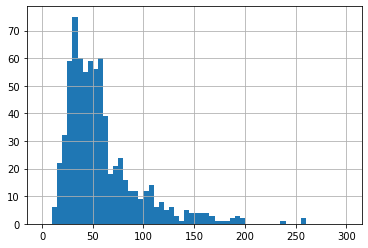

In [26]:
dt['Peak Dwell Time'].hist(bins=np.linspace(0, 300, 61))

In [27]:
dt['Off-Peak Dwell Time'].min()

10

In [28]:
dt['Off-Peak Dwell Time'].max()

227

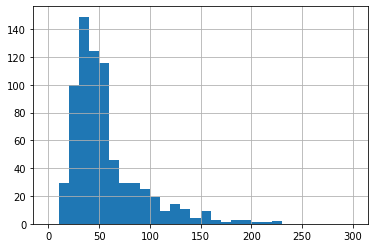

In [29]:
dt['Off-Peak Dwell Time'].hist(bins=np.linspace(0, 300, 31))

# Modelling

Components of the system will be described by Python classes. The parameters are passed as data frames.

## Trains

In [32]:
class Train(object):  
    def __init__(self, i, data, line, direction):
        self.data = data
        self.name = f"{line:s}-{direction:s} [Train {i:2d}]"
    
    def process(self):

        for i in range(len(self.data)):
            
            here = self.data.at[i, 'From']
            dest = self.data.at[i, 'To']
                       
            dwelltime = self.data.at[i, 'Off-Peak Dwell Time']
            yield env.timeout(dwelltime)
            print(f"{now():s} {self.name:s} dep {here:s} for {dest:s}")
            
            drivetime = self.data.at[i, 'Drive Time']
            yield env.timeout(drivetime)
            print(f"{now():s} {self.name:s} arr {dest:s}")


## Tracks

A track describes a direction of a line. The parameters describing a track are:
- The start and stop times of the line (for example 6:00 to 23:00),
- The time between trains (for example every 5 minutes), but this may vary during the day.

The parameters for a line will later be taken from the line table. For the time being we use a simple procedure running the simulation of a single track.

In [51]:
def track(env, line, direction, start, stop, timing):

    # create a slice of data for the line
    data = dt[dt['Line']==line][dt['Direction']==direction].reset_index(drop=True)
    
    yield env.timeout(start-env.now) # the line starts operating at 6am
    
    for i in range(int((stop-start)/timing)):  
        
        t = Train(i, data, line, direction)
        env.process(t.process())
        yield env.timeout(timing)

# Utilities

Format time in seconds as hh:mm:ss

In [34]:
def daytime(t):
    t=int(t)
    return f"{t//3600:02d}:{(t%3600)//60:02d}:{t%60:02d}"
def now():
    return daytime(env.now)

# System Verification

As a first step we verify that the trains are running in parallel.

In [52]:
env = simpy.Environment()
env.process(track(line='Central', direction='Eastbound', start=6*3600, stop=7*3600, timing=300))
env.run()

06:00:33 Central-Eastbound [Train  0] dep WEST RUISLIP for RUISLIP GARDENS
06:02:30 Central-Eastbound [Train  0] arr RUISLIP GARDENS
06:02:50 Central-Eastbound [Train  0] dep RUISLIP GARDENS for SOUTH RUISLIP
06:04:00 Central-Eastbound [Train  0] arr SOUTH RUISLIP
06:04:24 Central-Eastbound [Train  0] dep SOUTH RUISLIP for NORTHOLT
06:05:33 Central-Eastbound [Train  1] dep WEST RUISLIP for RUISLIP GARDENS
06:06:30 Central-Eastbound [Train  0] arr NORTHOLT
06:06:44 Central-Eastbound [Train  0] dep NORTHOLT for GREENFORD
06:07:30 Central-Eastbound [Train  1] arr RUISLIP GARDENS
06:07:50 Central-Eastbound [Train  1] dep RUISLIP GARDENS for SOUTH RUISLIP
06:08:30 Central-Eastbound [Train  0] arr GREENFORD
06:09:00 Central-Eastbound [Train  1] arr SOUTH RUISLIP
06:09:02 Central-Eastbound [Train  0] dep GREENFORD for PERIVALE
06:09:24 Central-Eastbound [Train  1] dep SOUTH RUISLIP for NORTHOLT
06:10:33 Central-Eastbound [Train  2] dep WEST RUISLIP for RUISLIP GARDENS
06:10:45 Central-Eastbou

# References

[SimPy](https://simpy.readthedocs.io/en/latest/contents.html)